In [8]:
import torch
import torch.nn as nn
from torch import Tensor
from torchsummary import summary

import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import numpy as np
import os
import copy
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.long

from einops import rearrange, repeat, reduce
from einops.layers.torch import Rearrange, Reduce

In [9]:
transform = T.Compose([
                T.ToTensor()
            ])

dataset_train = dset.MNIST('data', train=True, download=True, transform=transform)
dataset_test = dset.MNIST('data', train=False, download=True, transform=transform)

1.2%

100.0%


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



102.8%

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw




9.6%

100.0%


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



112.7%

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



torch.Size([1, 1, 28, 28])

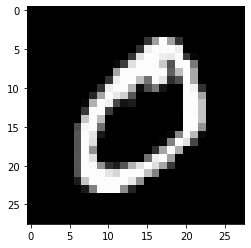

In [10]:
x = dataset_train[1][0]

plt.imshow( x[0], cmap='gray' )
x = x.unsqueeze(0) # add batch dim
x.size()

In [11]:
class image_embedding(nn.Module):
  def __init__(self, in_channels: int = 3, img_size: int = 224, patch_size: int = 16, emb_dim: int = 16*16*3):
    super().__init__()

    self.rearrange = Rearrange('b c (num_w p1) (num_h p2) -> b (num_w num_h) (p1 p2 c) ', p1=patch_size, p2=patch_size)
    self.linear = nn.Linear(in_channels * patch_size * patch_size, emb_dim)

    self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))
    
    n_patches = img_size * img_size // patch_size**2
    self.positions = nn.Parameter(torch.randn(n_patches + 1, emb_dim))

  def forward(self, x):
    batch, channel, width, height = x.shape

    x = self.rearrange(x) # flatten patches 
    x = self.linear(x) # embedded patches 

    # ================ ToDo1 ================ #
    c = repeat(self.cls_token, '() n d -> b n d', b=batch)
    x = torch.cat((c, x), dim=1)
    x = x + self.positions
    # ======================================= #
    return x

emb = image_embedding(1, 28, 4, 4*4)(x)
emb.shape

torch.Size([1, 50, 16])

In [12]:
class multi_head_attention(nn.Module):
    def __init__(self, emb_dim: int = 16*16*3, num_heads: int = 8, dropout_ratio: float = 0.2, verbose = False, **kwargs):
        super().__init__()
        self.v = verbose

        self.emb_dim = emb_dim 
        self.num_heads = num_heads 
        self.scaling = (self.emb_dim // num_heads) ** -0.5
        
        self.value = nn.Linear(emb_dim, emb_dim)
        self.key = nn.Linear(emb_dim, emb_dim)
        self.query = nn.Linear(emb_dim, emb_dim)
        self.att_drop = nn.Dropout(dropout_ratio)

        self.linear = nn.Linear(emb_dim, emb_dim)
                
    def forward(self, x: Tensor) -> Tensor:
        # query, key, value
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        if self.v: print(Q.size(), K.size(), V.size()) 

        # q = k = v = patch_size**2 + 1 & h * d = emb_dim
        Q = rearrange(Q, 'b q (h d) -> b h q d', h=self.num_heads)
        K = rearrange(K, 'b k (h d) -> b h d k', h=self.num_heads)
        V = rearrange(V, 'b v (h d) -> b h v d', h=self.num_heads)
        if self.v: print(Q.size(), K.size(), V.size()) 

        ## scaled dot-product
        weight = torch.matmul(Q, K) 
        weight = weight * self.scaling
        if self.v: print(weight.size()) 
        
        attention = torch.softmax(weight, dim=-1)
        attention = self.att_drop(attention) 
        if self.v: print(attention.size())

        context = torch.matmul(attention, V) 
        context = rearrange(context, 'b h q d -> b q (h d)')
        if self.v: print(context.size())

        x = self.linear(context)
        return x , attention

feat, att = multi_head_attention(4*4, 4, verbose=True)(emb)
feat.shape, att.shape

torch.Size([1, 50, 16]) torch.Size([1, 50, 16]) torch.Size([1, 50, 16])
torch.Size([1, 4, 50, 4]) torch.Size([1, 4, 4, 50]) torch.Size([1, 4, 50, 4])
torch.Size([1, 4, 50, 50])
torch.Size([1, 4, 50, 50])
torch.Size([1, 50, 16])


(torch.Size([1, 50, 16]), torch.Size([1, 4, 50, 50]))

In [13]:
class mlp_block(nn.Module):
    def __init__(self, emb_dim: int = 16*16*3, forward_dim: int = 4, dropout_ratio: float = 0.2, **kwargs):
        super().__init__()
        self.linear_1 = nn.Linear(emb_dim, forward_dim * emb_dim)
        self.dropout = nn.Dropout(dropout_ratio)
        self.linear_2 = nn.Linear(forward_dim * emb_dim, emb_dim)
        
    def forward(self, x):
        x = self.linear_1(x)
        x = nn.functional.gelu(x)
        x = self.dropout(x) 
        x = self.linear_2(x)
        return x

In [14]:
class encoder_block(nn.Sequential):
    def __init__(self, emb_dim:int = 16*16*3, num_heads:int = 8, forward_dim: int = 4, dropout_ratio:float = 0.2):
        super().__init__()

        self.norm_1 = nn.LayerNorm(emb_dim)
        self.mha = multi_head_attention(emb_dim, num_heads, dropout_ratio)

        self.norm_2 = nn.LayerNorm(emb_dim)
        self.mlp = mlp_block(emb_dim, forward_dim, dropout_ratio)

        self.residual_dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):
        # ================ ToDo2 ================ #
        x_ = self.norm_1(x)
        x_, attention = self.mha(x_)
        x = x_ + self.residual_dropout(x)

        x_ = self.norm_2(x)
        x_ = self.mlp(x_)
        x = x_ + self.residual_dropout(x)
        # ======================================= #
        return x, attention
        
feat, att = encoder_block(4*4, 2, 4)(emb)
feat.shape, att.shape

(torch.Size([1, 50, 16]), torch.Size([1, 2, 50, 50]))

In [15]:
class vision_transformer(nn.Module):
    """ Vision Transformer model
    classifying input images (x) into classes
    """
    def __init__(self, in_channel: int = 3, img_size:int = 224, 
                 patch_size: int = 16, emb_dim:int = 16*16*3, 
                 n_enc_layers:int = 15, num_heads:int = 3, 
                 forward_dim:int = 4, dropout_ratio: float = 0.2, 
                 n_classes:int = 1000):
        super().__init__()


        # ================ ToDo3 ================ #
        self.image_emb = image_embedding(in_channel, img_size, patch_size, emb_dim)
        self.transformer_encoders = nn.ModuleList([encoder_block(emb_dim, num_heads, forward_dim, dropout_ratio) for _ in range(n_enc_layers)])
        # ======================================= #
        
        self.reduce_layer = Reduce('b n e -> b e', reduction='mean')
        self.normalization = nn.LayerNorm(emb_dim)
        self.classification_head = nn.Linear(emb_dim, n_classes) 

    def forward(self, x):
        # ================ ToDo3 ================ #
        # (1) image embedding
        x = self.image_emb(x)

        # (2) transformer_encoder
        attentions = []
        for encoder in self.transformer_encoders:
            x, att = encoder(x)
            attentions.append(att)
        # ======================================= #

        # classification head
        x = self.reduce_layer(x)
        x = self.normalization(x)
        x = self.classification_head(x)

        return x, attentions

y, att = vision_transformer(1, 28, 4, 4*4, 3, 2, 4, 0.2, 10)(x)
y.shape, att[0].shape

(torch.Size([1, 10]), torch.Size([1, 2, 50, 50]))

In [16]:
model = vision_transformer(1, 28, 4, 4*4, 3, 2, 4, 0.2, 10)
model.to(device)

num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

batch_size = 64
dataloaders_train = DataLoader(dataset_train, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(0, len(dataset_train) * 4//5)))
dataloaders_valid = DataLoader(dataset_train, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(len(dataset_train) * 4//5, len(dataset_train))))
dataloaders_test = DataLoader(dataset_test, batch_size=batch_size)

In [17]:
for epoch in range(num_epochs):
    print('*** Epoch {} ***'.format(epoch))

    # Training
    model.train()  
    running_loss, running_acc = 0.0, 0.0
        
    for idx, (inputs, labels) in enumerate(dataloaders_train):
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward
      with torch.set_grad_enabled(True):
        outputs, _ = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.shape[0]
        running_acc += torch.sum(preds == labels.data)
    running_acc /= (idx+1) * batch_size
    print('{} Loss: {:.4f} Acc: {:.4f}'.format('train', running_loss, running_acc))

    # Validation
    model.eval()  
    running_acc = 0.0
        
    for idx, (inputs, labels) in enumerate(dataloaders_valid):
      inputs = inputs.to(device)
      labels = labels.to(device)

      with torch.set_grad_enabled(False):
        outputs, _ = model(inputs)
        _, preds = torch.max(outputs, 1)

        # statistics
        running_acc += torch.sum(preds == labels.data)
    running_acc /= (idx+1) * batch_size
    print('{} Acc: {:.4f}\n'.format('valid', running_acc))

*** Epoch 0 ***
train Loss: 82385.6141 Acc: 0.3666
valid Acc: 0.6362

*** Epoch 1 ***
train Loss: 42538.1641 Acc: 0.7036
valid Acc: 0.8018

*** Epoch 2 ***
train Loss: 30255.6351 Acc: 0.8026
valid Acc: 0.8499

*** Epoch 3 ***
train Loss: 25218.1451 Acc: 0.8387
valid Acc: 0.8779

*** Epoch 4 ***
train Loss: 22118.9168 Acc: 0.8574
valid Acc: 0.8812

*** Epoch 5 ***
train Loss: 20125.0684 Acc: 0.8715
valid Acc: 0.8989

*** Epoch 6 ***
train Loss: 18562.8572 Acc: 0.8806
valid Acc: 0.9048

*** Epoch 7 ***
train Loss: 17421.9398 Acc: 0.8879
valid Acc: 0.9126

*** Epoch 8 ***
train Loss: 16116.6607 Acc: 0.8973
valid Acc: 0.9166

*** Epoch 9 ***
train Loss: 15220.0015 Acc: 0.9016
valid Acc: 0.9193



In [18]:
model.eval()  
running_acc = 0.0
    
for idx, (inputs, labels) in enumerate(dataloaders_test):
  inputs = inputs.to(device)
  labels = labels.to(device)

  with torch.set_grad_enabled(False):
    outputs, _ = model(inputs)
    _, preds = torch.max(outputs, 1)

    # statistics
    running_acc += torch.sum(preds == labels.data)
running_acc /= (idx+1) * batch_size
print('{} Acc: {:.4f}\n'.format('test', running_acc))

test Acc: 0.9226



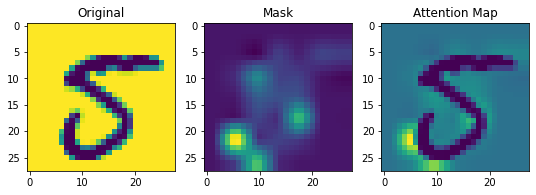

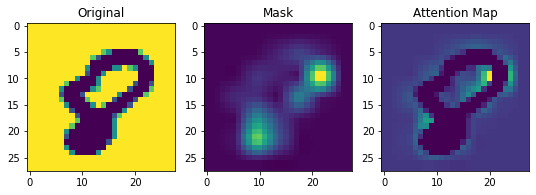

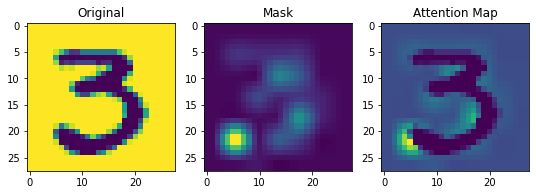

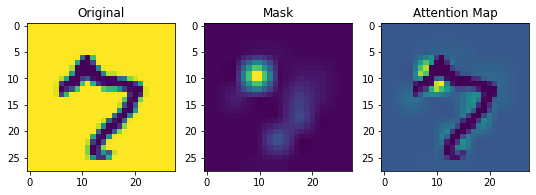

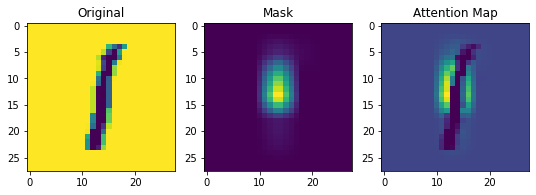

In [19]:
idxs = np.random.choice(range(len(dataset_test.data)), 5, False)
for idx in idxs:
  img = dataset_test.data[idx]
  img = 255 - img 

  _, attentions = model(img.unsqueeze(0).unsqueeze(1).to(device, torch.float))

  # Average the attention weights across all heads.
  att_mat = torch.stack(attentions).squeeze(1)
  att_mat = att_mat.cpu().detach()
  att_mat = reduce(att_mat, 'b h len1 len2 -> b len1 len2', 'mean')

  residual_att = torch.eye(att_mat.size(1))
  aug_att_mat = att_mat + residual_att
  aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

  # Recursively multiply the weight matrices
  joint_attentions = torch.zeros(aug_att_mat.size())
  joint_attentions[0] = aug_att_mat[0]

  for n in range(1, aug_att_mat.size(0)):
      joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
      
  # Attention from the output token to the input space.
  v = joint_attentions[-1]
  grid_size = int(np.sqrt(aug_att_mat.size(-1)))
  mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
  mask = cv2.resize(mask / mask.max(), (img.shape[1], img.shape[0]))[..., np.newaxis]
  mask = mask.squeeze()
  result = (mask * img.numpy()).astype("uint8")

  # plotting
  fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(9, 3)) 
  ax1.set_title('Original')
  ax2.set_title('Mask')
  ax3.set_title('Attention Map')
  _ = ax1.imshow(img)
  _ = ax2.imshow(mask)
  _ = ax3.imshow(result)